# Import libs

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Read data

In [2]:
change_df = pd.read_csv('../datasets/group_people.csv')
bots_df = pd.read_csv('../datasets/bots.csv')
users_df = pd.read_csv('../datasets/users.csv')
data = pd.concat([bots_df, users_df, change_df])


source_features = ['has_photo','has_mobile','is_friend','can_post','can_see_all_posts',
            'can_see_audio','can_write_private_message','can_send_friend_request',
            'can_be_invited_group','followers_count','blacklisted','blacklisted_by_me',
            'is_favorite','is_hidden_from_feed','common_count','university','faculty',
            'graduation','relation','verified','deactivated','friend_status','can_access_closed',
            'is_closed', 'city_id','country_id','last_seen_platform','last_seen_time',
            'interests_bool', 'books_bool', 'tv_bool', 'quotes_bool', 'about_bool',
            'games_bool', 'movies_bool', 'activities_bool', 'music_bool', 'mobile_phone_bool',
            'home_phone_bool', 'site_bool', 'status_bool', 'university_bool',
            'university_name_bool', 'faculty_bool', 'faculty_name_bool', 'graduation_bool',
            'home_town_bool', 'relation_bool', 'personal_bool', 'universities_bool',
            'schools_bool', 'occupation_bool', 'education_form_bool', 'education_status_bool',
            'relation_partner_bool', 'skype_bool', 'twitter_bool', 'livejournal_bool',
            'instagram_bool', 'facebook_bool', 'facebook_name_bool', 'relatives_in_friends_bool',
            'change_nickname_bool', 'partner_in_friends_bool', 'partner_in_friends_bool',
            'posts_count', 'users_subscriptions_count', 'groups_subscriptions_count',
            'albums_count', 'audios_count', 'gifts_count', 'pages_count', 'photos_count',
            'subscriptions_count', 'videos_count', 'video_playlists_count', 'subscriptions_followers_coef',
            'subscriptions_followers_coef_norm']

# Feature selection

In [334]:
X = data[source_features]
y = data['bots']

# Создаем модель линейной регрессии
X.fillna(0, inplace=True)
model = LinearRegression()

# Выполняем RFE с использованием модели линейной регрессии
selected_features_list = []
features_numbers = list(range(10, 50, 5))
for i in features_numbers:
    rfe = RFE(model, n_features_to_select=i)
    fit = rfe.fit(X, y)

    # Добавляем результаты отбора признаков
    selected_features_list.append(list(np.compress(fit.support_, source_features)))

/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_35448/1245993805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


# Class for collecting results

In [322]:
class Result:
    def __init__(self, selected_features, accuracy, precision, recall, auc, f1, fpr, tpr, roc_auc):
        self.selected_features = selected_features
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.auc = auc
        self.f1 = f1
        self.fpr = fpr
        self.tpr = tpr
        self.roc_auc = roc_auc
    
    @property
    def metrics_sum(self):
        return self.accuracy + self.precision + self.recall + self.auc + self.f1

# F1 score function

In [323]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))


# Train model

In [324]:
# Выбираем нужные признаки и целевую переменную
results = []
for selected_features in selected_features_list:
    # Разделяем данные на обучающую и тестовую выборки
    train_data, test_data, train_labels, test_labels = train_test_split(data[selected_features], data['bots'], test_size=0.2)
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    # Создаем модель нейронной сети
    model = tf.keras.models.Sequential([
        Dense(128, input_shape=(train_data.shape[1],), activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Компилируем модель
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC', f1])

    # Обучаем модель
    history = model.fit(train_data, train_labels, epochs=9, batch_size=128, validation_data=(test_data, test_labels))

    # Оцениваем точность модели
    test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_data, test_labels)

    
    # Roc кривая
    y_score = model.predict(test_data)
    y_true = test_labels

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    
    # Создаем модель result
    result = Result(selected_features, test_accuracy, test_precision, test_recall, test_auc, test_f1, fpr, tpr, roc_auc)
    results.append(result)

Epoch 1/9
57/57 [==============================] - 18s 258ms/step - loss: 1.8968 - accuracy: 0.7179 - precision: 0.5575 - recall: 0.2235 - auc: 0.7705 - f1: 0.2765 - val_loss: 1.3030 - val_accuracy: 0.9310 - val_precision: 0.9901 - val_recall: 0.7692 - val_auc: 0.9054 - val_f1: 0.8730
Epoch 2/9
57/57 [==============================] - 6s 100ms/step - loss: 1.0308 - accuracy: 0.7387 - precision: 0.5910 - recall: 0.3774 - auc: 0.8157 - f1: 0.3933 - val_loss: 0.8033 - val_accuracy: 0.7129 - val_precision: 1.0000 - val_recall: 0.0077 - val_auc: 0.9166 - val_f1: 0.0148
Epoch 3/9
57/57 [==============================] - 5s 88ms/step - loss: 0.7001 - accuracy: 0.7430 - precision: 0.6524 - recall: 0.2800 - auc: 0.8245 - f1: 0.3510 - val_loss: 0.6055 - val_accuracy: 0.7134 - val_precision: 1.0000 - val_recall: 0.0096 - val_auc: 0.9178 - val_f1: 0.0181
Epoch 4/9
57/57 [==============================] - 5s 93ms/step - loss: 0.5711 - accuracy: 0.7625 - precision: 0.6574 - recall: 0.4108 - auc: 0.8

57/57 [==============================] - 0s 5ms/step
Epoch 1/9
57/57 [==============================] - 19s 282ms/step - loss: 2.2503 - accuracy: 0.7963 - precision: 0.7596 - recall: 0.4426 - auc: 0.7995 - f1: 0.5635 - val_loss: 1.5605 - val_accuracy: 0.8575 - val_precision: 0.9096 - val_recall: 0.5897 - val_auc: 0.9126 - val_f1: 0.6667
Epoch 2/9
57/57 [==============================] - 6s 101ms/step - loss: 1.2040 - accuracy: 0.8617 - precision: 0.8521 - recall: 0.6370 - auc: 0.9184 - f1: 0.7217 - val_loss: 0.9014 - val_accuracy: 0.8848 - val_precision: 0.8677 - val_recall: 0.7326 - val_auc: 0.9365 - val_f1: 0.7420
Epoch 3/9
57/57 [==============================] - 5s 96ms/step - loss: 0.7518 - accuracy: 0.8785 - precision: 0.8475 - recall: 0.7122 - auc: 0.9295 - f1: 0.7722 - val_loss: 0.6172 - val_accuracy: 0.8870 - val_precision: 0.8611 - val_recall: 0.7491 - val_auc: 0.9369 - val_f1: 0.7486
Epoch 4/9
57/57 [==============================] - 5s 96ms/step - loss: 0.5492 - accuracy: 0

# Plot graphs of metrics

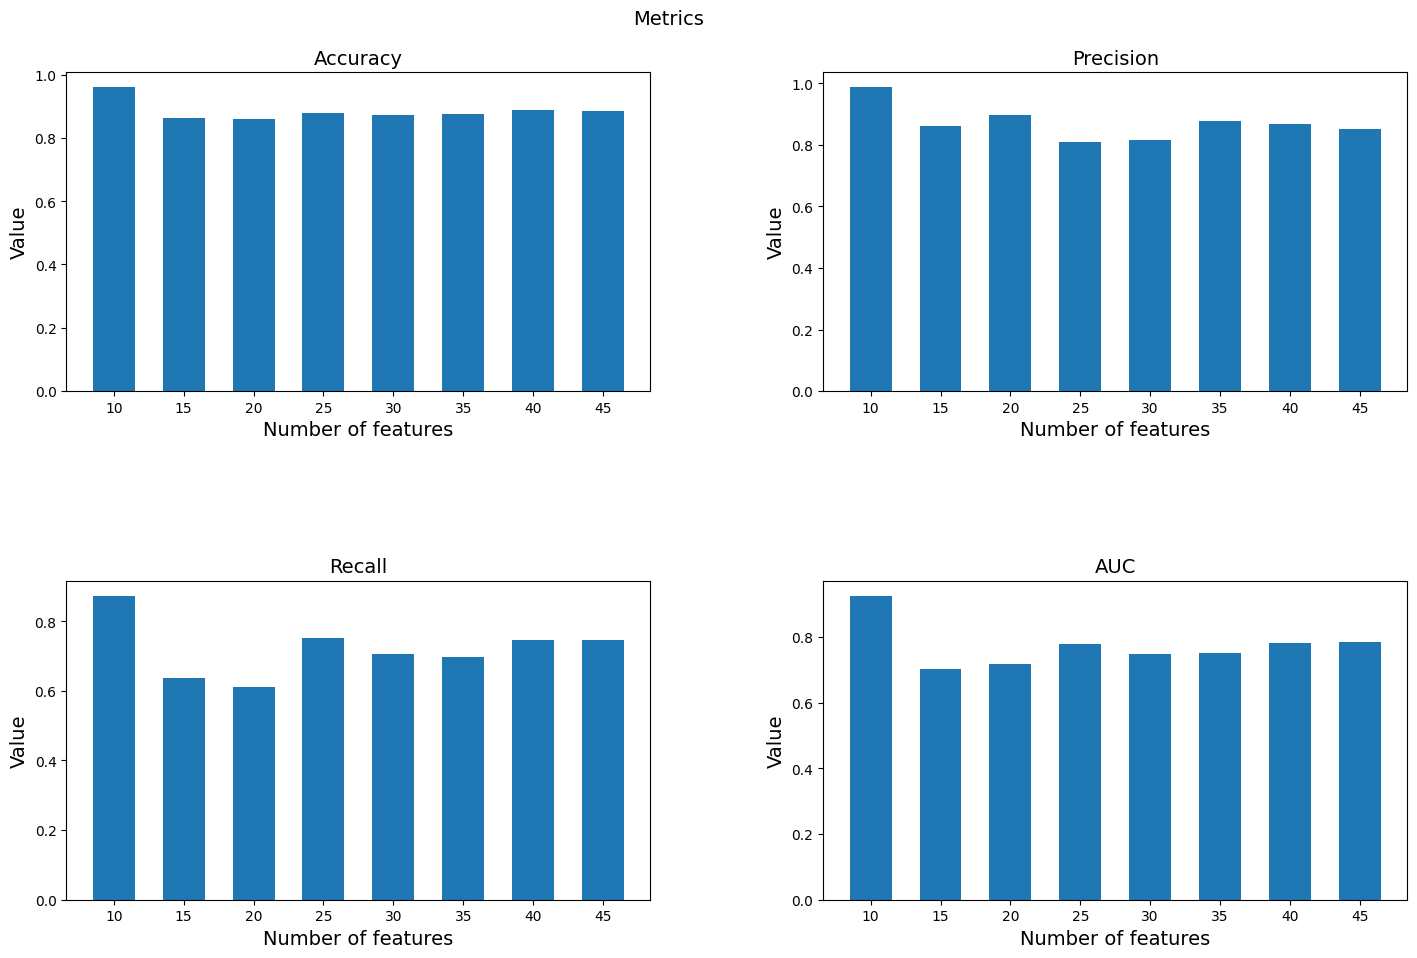

In [333]:
# Строим график столбцов
accuracy_values = [result.accuracy for result in results]
precision_values = [result.precision for result in results]
recall_values = [result.recall for result in results]
auc_values = [result.auc for result in results]
f1_values = [result.f1 for result in results]

# Добавляем заголовок и подписи осей
fig, axs = plt.subplots(2, 2)

# Первый график
axs[0, 0].bar(features_numbers, accuracy_values, width=3)
axs[0, 0].set_title('Accuracy', fontsize=14)
axs[0, 0].set_xlabel('Number of features', fontsize=14)
axs[0, 0].set_ylabel('Value', fontsize=14)

# Второй график
axs[0, 1].bar(features_numbers, precision_values, width=3)
axs[0, 1].set_title('Precision', fontsize=14)
axs[0, 1].set_xlabel('Number of features', fontsize=14)
axs[0, 1].set_ylabel('Value', fontsize=14)

# Третий график
axs[1, 0].bar(features_numbers, recall_values, width=3)
axs[1, 0].set_title('Recall', fontsize=14)
axs[1, 0].set_xlabel('Number of features', fontsize=14)
axs[1, 0].set_ylabel('Value', fontsize=14)

# Четвертый график
axs[1, 1].bar(features_numbers, f1_values, width=3)
axs[1, 1].set_title('AUC', fontsize=14)
axs[1, 1].set_xlabel('Number of features', fontsize=14)
axs[1, 1].set_ylabel('Value', fontsize=14)

# Настраиваем расположение графиков и добавляем общий заголовок
fig.tight_layout()
fig.suptitle('Metrics', fontsize=14)

# Сохраняем график
fig.set_size_inches(15.5, 10.5, forward=True)
fig.savefig('Metrics.png', dpi=300)
plt.show()

# Plot ROC curves

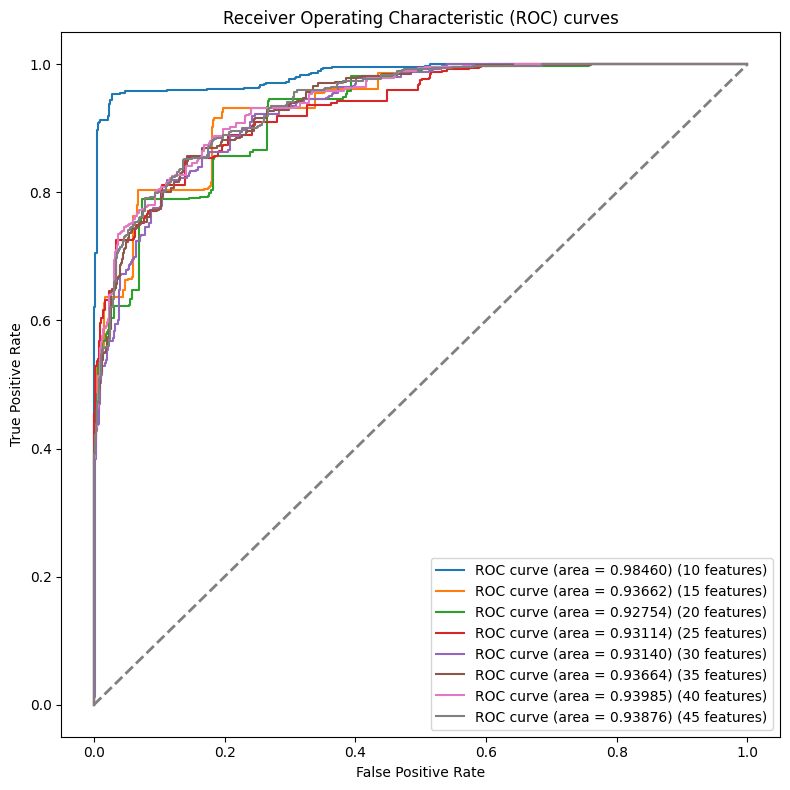

In [327]:
fig = plt.figure(figsize=(8, 8))

# Строим ROC кривые
for i in range(len(results)):
    plt.plot(
        results[i].fpr,
        results[i].tpr,
        label=f'ROC curve (area = %0.5f) ({len(results[i].selected_features)} features)'% results[i].roc_auc
    )

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")

# Сохраняем график
fig.tight_layout()
plt.savefig('ROC-curves.png', dpi=300)
plt.show()